In [1]:
import sys
sys.path.insert(1,"../src")
import tensorflow as tf
import keras as tfk
tfkl = tf.keras.layers
import matplotlib.pyplot as plt
import util
import GA_util
import pandas as pd
import os
import numpy as np
print('loaded modules')

loaded modules


In [2]:
data = pd.read_csv('../data/UTR_data/designed_library.csv')


y = data['rl'].values


designed = np.load('../data/UTR_data/UTR_encoded.npy')
designed_ppms = GA_util.prototype_ppms_fast(designed)

indices = np.arange(0,designed.shape[0])



/var/folders/4j/njj9l0k14bxb_81mvyh1xxf40000gn/T/ipykernel_86818/2892836914.py:1: DtypeWarning: Columns (33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data/UTR_data/designed_library.csv')


(100017, 1)


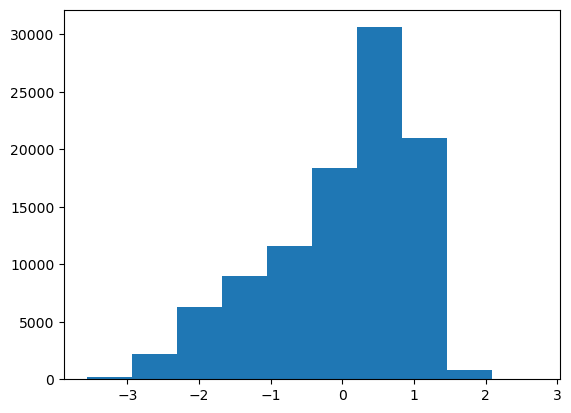

In [3]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler


stand = StandardScaler()

stand.fit(y.reshape(-1,1))
y_transformed = stand.transform(y.reshape(-1,1))

plt.hist(y_transformed)


est =  KBinsDiscretizer(n_bins=10,encode='ordinal') #Quantile transform
encoded_vals =est.fit_transform(y.reshape(-1,1))
print(encoded_vals.shape)



from sklearn.model_selection import train_test_split

In [4]:
# Optimus 5' Code

from keras.layers import Conv1D, Dropout,Flatten,Dense,Activation
import keras

def train_optimus_model(x_train,y_train,val, border_mode='same', inp_len=50, nodes=40, layers=3, filter_len=8, nbr_filters=120,
                dropout1=0, dropout2=0, dropout3=0, nb_epoch=3):
    ''' Build model archicture and fit.'''
    model = keras.Sequential()
    if layers >= 1:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 4), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
    if layers >= 2:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout1))
    if layers >= 3:
        model.add(Conv1D(activation="relu", input_shape=(inp_len, 1), padding=border_mode, filters=nbr_filters, kernel_size=filter_len))
        model.add(Dropout(dropout2))
    model.add(Flatten())

    model.add(Dense(nodes))
    model.add(Activation('relu'))
    model.add(Dropout(dropout3))
    
    model.add(Dense(1))
    model.add(Activation('linear'))

    #compile the model
    optimizer = tfk.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    # optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    hist = model.fit(x_train, y_train, batch_size=128, epochs=nb_epoch, verbose=1,validation_data=val)
    return model,hist



# model = train_model(seq_e_train, e_train['scaled_rl'], nb_epoch=3,border_mode='same',
#                    inp_len=50, nodes=40, layers=3, nbr_filters=120, filter_len=8, dropout1=0,
#                    dropout2=0,dropout3=0.2)

In [5]:
from GA_util import create_joint_model
from sklearn.metrics import r2_score
from scipy.stats import spearmanr


fold = 1

joint_mse_save = []
joint_r2_save = []
joint_spearman_save = []


optimus_mse_save = []
optimus_r2_save = []
optimus_spearman_save = []

seq_mse_save = []
seq_r2_save = []
seq_spearman_save = []





for i in range(fold):

    utr_train,utr_test,y_train,y_test,indices_train,indices_test = train_test_split(designed,
                                                                                    y_transformed,
                                                                                    indices,
                                                                                    test_size=0.20,
                                                                                    stratify=encoded_vals)
    ppm_train = designed_ppms[indices_train,:,:]
    ppm_test = designed_ppms[indices_test,:,:]

    #Trian optimus model first
    optimus_model,optimus_hist = train_optimus_model(tf.transpose(utr_train,(0,2,1)),
                                                     y_train,val = [tf.transpose(utr_test,(0,2,1)),y_test])

    #Append the metrics to the save list
    optimus_mse = optimus_hist.history['val_loss'][-1]
    optimus_mse_save.append(optimus_mse)

    optimus_predictions = optimus_model(tf.transpose(utr_test,(0,2,1)))

    optimus_r2 = r2_score(y_test,optimus_predictions)
    optimus_r2_save.append(optimus_r2)

    optimus_spearman = spearmanr(y_test,optimus_predictions)[0]
    optimus_spearman_save.append(optimus_spearman)


    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    # optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    joint_model = GA_util.create_SANDSTORM(seq_len=50,
                                           ppm_len=50,
                                           latent_dim=64,
                                           internal_activation='relu')
    
    joint_model.compile(optimizer=optimizer,loss='mse')
    epochs=20
    
    hist = joint_model.fit(
        [utr_train,ppm_train],y_train,batch_size=64,validation_data=[[utr_test,ppm_test],y_test],epochs=epochs)


    mse = np.min(hist.history['val_loss'])
    joint_mse_save.append(mse)

    joint_predictions = joint_model([utr_test,ppm_test])

    joint_r2 = r2_score(y_test,joint_predictions)
    joint_r2_save.append(joint_r2)


    joint_spearman = spearmanr(y_test,joint_predictions)[0]
    joint_spearman_save.append(joint_spearman)
    

Metal device set to: Apple M1 Max
Epoch 1/3


2024-11-30 14:38:13.703129: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


626/626 [==============================] - 7s 11ms/step - loss: 0.3813 - val_loss: 0.2525
Epoch 2/3
626/626 [==============================] - 7s 11ms/step - loss: 0.2234 - val_loss: 0.2072
Epoch 3/3
626/626 [==============================] - 7s 11ms/step - loss: 0.1907 - val_loss: 0.1914
Epoch 1/20
1251/1251 [==============================] - 16s 12ms/step - loss: 0.4276 - val_loss: 0.2851
Epoch 2/20
1251/1251 [==============================] - 15s 12ms/step - loss: 0.2684 - val_loss: 0.2583
Epoch 3/20
1251/1251 [==============================] - 15s 12ms/step - loss: 0.2480 - val_loss: 0.2397
Epoch 4/20
1251/1251 [==============================] - 14s 11ms/step - loss: 0.2355 - val_loss: 0.2337
Epoch 5/20
1251/1251 [==============================] - 14s 11ms/step - loss: 0.2286 - val_loss: 0.2332
Epoch 6/20
1251/1251 [==============================] - 14s 11ms/step - loss: 0.2209 - val_loss: 0.2352
Epoch 7/20
1251/1251 [==============================] - 15s 12ms/step - loss: 0.2159 -

In [8]:
# joint_model.save("models/SADNSTORM_5UTR_11_30")


INFO:tensorflow:Assets written to: models/SADNSTORM_5UTR_11_30/assets


INFO:tensorflow:Assets written to: models/SADNSTORM_5UTR_11_30/assets


In [11]:
joint_params = np.sum([np.prod(v.get_shape()) for v in joint_model.trainable_weights])
print(joint_params)

optimus_params = np.sum([np.prod(v.get_shape()) for v in optimus_model.trainable_weights])
print(optimus_params)

optimus_params = np.sum([np.prod(v.get_shape()) for v in optimus_model.trainable_weights])

14473
474681


In [12]:
joint_model_bars = [np.mean(joint_mse_save),
                    np.mean(joint_r2_save),
                    np.mean(joint_spearman_save),
                    joint_params/optimus_params]


joint_model_variances = [np.std(joint_mse_save),
                         np.std(joint_r2_save),
                         np.std(joint_spearman_save),
                        0]

optimus_model_bars = [np.mean(optimus_mse_save),
                    np.mean(optimus_r2_save),
                    np.mean(optimus_spearman_save),
                    optimus_params/optimus_params]

optimus_model_variances = [np.std(optimus_mse_save),
                         np.std(optimus_r2_save),
                         np.std(optimus_spearman_save),
                         0]

seq_model_bars = [np.mean(seq_mse_save),
                 np.mean(seq_r2_save),
                 np.mean(seq_spearman_save)]

seq_model_variances = [np.std(seq_mse_save),
                      np.std(seq_r2_save),
                      np.std(seq_spearman_save)]

/opt/homebrew/Caskroom/miniforge/base/envs/GARDN/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/GARDN/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/Caskroom/miniforge/base/envs/GARDN/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/Caskroom/miniforge/base/envs/GARDN/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/homebrew/Caskroom/miniforge/base/envs/GARDN/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in do

In [24]:
# np.save('stat_tests/SANDSTORM_UTR_means_11_08.npy',joint_model_bars)
# np.save('stat_tests/optimus_model_means_11_08.npy',optimus_model_bars)
# np.save('stat_tests/seq_model_means_11_08.npy',seq_model_bars)

# np.save('stat_tests/SANDSTORM_UTR_std_11_08.npy',joint_model_variances)
# np.save('stat_tests/optimus_model_std_11_08.npy',optimus_model_variances)
# np.save('stat_tests/seq_model_std_11_08.npy',seq_model_variances)

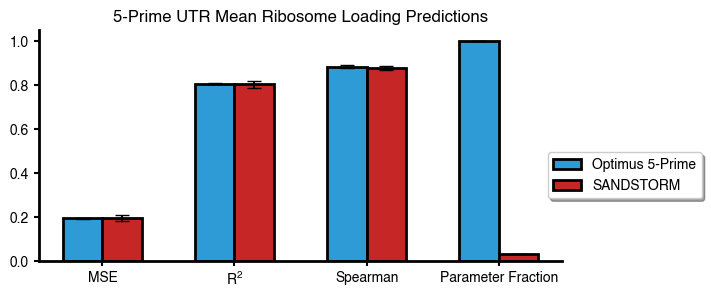

In [14]:
# joint_model_bars = np.load('stat_tests/joint_utr_model_metrics.npy')
# joint_model_variances = np.load('stat_tests/joint_utr_model_variances.npy')

# optimus_model_bars = np.load('stat_tests/optimus_model_metrics.npy')
# optimus_model_variances = np.load('stat_tests/optimus_model_variances.npy')



RED = '#C62626'
BLUE = '#2E9AD6'

barwidth = 0.3
plt.rcParams.update({'font.size': 10,'font.family':'Helvetica'})
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Helvetica'
plt.rcParams['mathtext.it'] = 'Helvetica:italic'
plt.rcParams['mathtext.bf'] = 'Helvetica:bold'
r1 = np.arange(len(joint_model_bars))
r2 = [x + barwidth for x in r1]

plt.figure(figsize=(6.75,3))
plt.title("5-Prime UTR Mean Ribosome Loading Predictions")
plt.bar(r1, optimus_model_bars, width = barwidth, color = BLUE,alpha=1, yerr=optimus_model_variances, capsize=5, label='Optimus 5-Prime',edgecolor='black',linewidth=2)
plt.bar(r2, joint_model_bars, width = barwidth, color = RED,alpha=1, yerr=joint_model_variances, capsize=5, label='SANDSTORM',edgecolor='black',linewidth=2)
plt.xticks([r + (barwidth/2) for r in range(len(joint_model_bars))], ['MSE', r'R$^{\rm 2}$','Spearman','Parameter Fraction'])
plt.subplot().spines['right'].set_visible(False)
plt.subplot().spines['top'].set_visible(False)
plt.subplot().spines['left'].set_linewidth(2.0)
plt.subplot().spines['bottom'].set_linewidth(2.0)
plt.subplot().xaxis.set_tick_params(width=1.5)
plt.subplot().yaxis.set_tick_params(width=1.5)
plt.legend(loc='upper center', bbox_to_anchor=(1.12, 0.5),
          fancybox=True, shadow=True, ncol=1)
# plt.savefig('../figures/UTR Predictor.png',dpi=500,pad_inches=0.5,bbox_inches='tight')
# plt.savefig('../figures/UTR Predictor.svg',transparent=True,pad_inches=0.5)





In [19]:
import scipy
joint_model_bars
joint_model_variances

save = []
for i in range(len(joint_model_bars)-1):
    save.append(scipy.stats.ttest_ind_from_stats(joint_model_bars[i], 
                                     joint_model_variances[i], 
                                     3,
                                     seq_model_bars[i],
                                     seq_model_variances[i],
                                     3, equal_var=True, alternative='two-sided'))
    
    
save

[Ttest_indResult(statistic=nan, pvalue=nan),
 Ttest_indResult(statistic=nan, pvalue=nan),
 Ttest_indResult(statistic=nan, pvalue=nan)]

In [20]:
joint_r2_save

[0.7892041423757765, 0.803089030186767, 0.788220532492397]

In [21]:
optimus_r2_save

[0.6975590213796459, 0.6424154091959497, 0.7464788064198355]

In [32]:
seq_r2_save

[0.7991415518592063, 0.8006767601101572, 0.7830772877790682]

In [33]:
joint_spearman_save

[0.8800989180447899, 0.8782138641698715, 0.8789483021763719]

In [34]:
seq_spearman_save

[SignificanceResult(statistic=0.8733191039995697, pvalue=0.0),
 SignificanceResult(statistic=0.8744689585901669, pvalue=0.0),
 SignificanceResult(statistic=0.8646275825358265, pvalue=0.0)]

In [36]:
optimus_spearman_save

[0.8861356428249472, 0.888178668077588, 0.8816059111014719]